# Peak Beat Measure

This notebook is related to the [Trace Segmentation Tricuspid Doppler](https://github.com/nickninov/Computer-Vision/blob/main/Trace%20Segmentation%20Tricuspid%20Doppler.ipynb). The aim of this notebook is to calculate the max velocity a peak point for each heartbeat in an image.

This is done by the following steps:
1. Convert the image from BGR to HSV colour space
2. Detect the beatline (orange horizontal line). We find the Y value of the line. The line represents the beginning of the beat (which is located between 100 and -100). This helps us find where 0 starts from.
3. Detect the peak of the beat (as previously described in [Trace Segmentation Tricuspid Doppler](https://github.com/nickninov/Computer-Vision/blob/main/Trace%20Segmentation%20Tricuspid%20Doppler.ipynb)). This is done in the mask image.
4. For every beat the following steps are executed:
 - Calculate the distance from 0 (orange line) to peak point of the beat
 - Calculate the distance from peak to max number in pixels
 - Calculate the real velocity by the ratio - pixel to cm

In [ ]:
# Used to access the dataset on personal Google Drive
from google.colab import drive

In [ ]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from IPython.display import clear_output
%cd "/content/drive/MyDrive/Colab Notebooks/Practice/Deep Learning/PaddleOCR"

/content/drive/.shortcut-targets-by-id/1Old8bqwzWPzBVZdYfwAM5a-mpPsy74Dp/PaddleOCR


In [ ]:
!pip install paddlepaddle-gpu
!pip install -r requirements.txt

clear_output()

In [ ]:
!mkdir /content/model_detect

!wget https://paddleocr.bj.bcebos.com/dygraph_v2.0/en/det_r50_vd_db_v2.0_train.tar -P /content/ch_lite/
!tar xf /content/ch_lite/det_r50_vd_db_v2.0_train.tar -C /content/ch_lite/

!rm /content/ch_lite/det_r50_vd_db_v2.0_train.tar

!python3 tools/export_model.py -c configs/det/det_r50_vd_db.yml -o Global.pretrained_model=/content/ch_lite/det_r50_vd_db_v2.0_train/best_accuracy  Global.save_inference_dir=/content/result_model/DB_r50

In [ ]:
!mkdir /content/model_recog

!python3 tools/export_model.py -c configs/rec/rec_r34_vd_none_bilstm_ctc.yml -o Global.pretrained_model="./output/rec/r34_vd_none_bilstm_ctc/latest"  Global.save_inference_dir=/content/model_recog/

mkdir: cannot create directory ‘/content/model_recog’: File exists
/usr/local/lib/python3.7/dist-packages/skimage/data/__init__.py:107: DeprecationWarning: 
    Importing file_hash from pooch.utils is DEPRECATED. Please import from the
    top-level namespace (`from pooch import file_hash`) instead, which is fully
    backwards compatible with pooch >= 0.1.
    
  return file_hash(path) == expected_hash
/usr/local/lib/python3.7/dist-packages/scipy/fft/__init__.py:97: DeprecationWarning: The module numpy.dual is deprecated.  Instead of using dual, use the functions directly from numpy or scipy.
  from numpy.dual import register_func
/usr/local/lib/python3.7/dist-packages/scipy/special/orthogonal.py:81: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to 

In [ ]:
import sys 
sys.path.insert(0, "./tools/infer/")

from predict_det import TextDetector
from predict_rec import TextRecognizer
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import utility
from statistics import mode
from scipy.signal import argrelextrema, find_peaks
import time
import glob
plt.rcParams["figure.figsize"] = (10,10)

/usr/local/lib/python3.7/dist-packages/skimage/data/__init__.py:107: DeprecationWarning: 
    Importing file_hash from pooch.utils is DEPRECATED. Please import from the
    top-level namespace (`from pooch import file_hash`) instead, which is fully
    backwards compatible with pooch >= 0.1.
    
  return file_hash(path) == expected_hash
/usr/local/lib/python3.7/dist-packages/scipy/fft/__init__.py:97: DeprecationWarning: The module numpy.dual is deprecated.  Instead of using dual, use the functions directly from numpy or scipy.
  from numpy.dual import register_func
/usr/local/lib/python3.7/dist-packages/scipy/special/orthogonal.py:81: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional

In [ ]:
DETECT_MODEL_DIR = "/content/result_model/DB_r50"
RECOG_MODEL_DIR = "/content/model_recog"

In [ ]:
from ppocr.postprocess import build_post_process
from ppocr.data import create_operators

class MyTextDetector(TextDetector):
  def __init__(self, 
               model_dir,
               det_limit_side_len=960, 
               det_limit_type='max',
               det_db_thresh=0.3,
               det_db_box_thresh=0.5,
               det_db_unclip_ratio=2.0, # Zoom of bounding box
               use_dilation=False,
               det_db_score_mode="fast"):
    # self.det_algorithm = det_algorithm
    self.det_algorithm = "DB"
    pre_process_list = [
      {
        'DetResizeForTest': {
          'limit_side_len': det_limit_side_len,
          'limit_type': det_limit_type
        }
      }, {
        'NormalizeImage': {
          'std': [0.229, 0.224, 0.225],
          'mean': [0.485, 0.456, 0.406],
          'scale': '1./255.',
          'order': 'hwc'
        }
      }, {
        'ToCHWImage': None
      }, {
        'KeepKeys': {
          'keep_keys': ['image', 'shape']
        }
      }
    ]
    postprocess_params = {}
    postprocess_params['name'] = 'DBPostProcess'
    postprocess_params["thresh"] = det_db_thresh
    postprocess_params["box_thresh"] = det_db_box_thresh
    postprocess_params["max_candidates"] = 1000
    postprocess_params["unclip_ratio"] = det_db_unclip_ratio
    postprocess_params["use_dilation"] = use_dilation
    postprocess_params["score_mode"] = det_db_score_mode

    self.preprocess_op = create_operators(pre_process_list)
    self.postprocess_op = build_post_process(postprocess_params)
    self.predictor, self.input_tensor, self.output_tensors = get_predictor(model_dir)

class MyTextRecognizer(TextRecognizer):
  def __init__(
      self, 
      model_dir,
      rec_algorithm="CRNN",
      rec_image_shape=[3,32,100],
      rec_char_type='en',
      rec_batch_num=6,
      max_text_length=25,
      rec_char_dict_path="./ppocr/utils/en_dict.txt",
      use_space_char=True
      ):
    self.rec_image_shape = rec_image_shape
    self.character_type = rec_char_type
    self.rec_batch_num = rec_batch_num
    self.rec_algorithm = rec_algorithm
    self.max_text_length = max_text_length
    
    postprocess_params = {
      'name': 'CTCLabelDecode',
      "character_type": rec_char_type,
      "character_dict_path": rec_char_dict_path,
      "use_space_char": use_space_char
    }
    if self.rec_algorithm == "SRN":
      print("SRN_run")
      postprocess_params['name'] = 'SRNLabelDecode'

    self.postprocess_op = build_post_process(postprocess_params)
    self.predictor, self.input_tensor, self.output_tensors = get_predictor(model_dir)

In [ ]:
from paddle import inference

def nms(bounding_boxes, confidence_score, threshold):
    # If no bounding boxes, return empty list
    if len(bounding_boxes) == 0:
        return [], []

    # Bounding boxes
    boxes = np.array(bounding_boxes)

    # coordinates of bounding boxes
    start_x = boxes[:, 0]
    start_y = boxes[:, 1]
    end_x = boxes[:, 2]
    end_y = boxes[:, 3]

    # Confidence scores of bounding boxes
    score = np.array(confidence_score)

    # Picked bounding boxes
    picked_boxes = []
    picked_score = []

    # Compute areas of bounding boxes
    areas = (end_x - start_x + 1) * (end_y - start_y + 1)

    # Sort by confidence score of bounding boxes
    order = np.argsort(score)

    # Iterate bounding boxes
    while order.size > 0:
        # The index of largest confidence score
        index = order[-1]

        # Pick the bounding box with largest confidence score
        picked_boxes.append(bounding_boxes[index])
        picked_score.append(confidence_score[index])

        # Compute ordinates of intersection-over-union(IOU)
        x1 = np.maximum(start_x[index], start_x[order[:-1]])
        x2 = np.minimum(end_x[index], end_x[order[:-1]])
        y1 = np.maximum(start_y[index], start_y[order[:-1]])
        y2 = np.minimum(end_y[index], end_y[order[:-1]])

        # Compute areas of intersection-over-union
        w = np.maximum(0.0, x2 - x1 + 1)
        h = np.maximum(0.0, y2 - y1 + 1)
        intersection = w * h

        # Compute the ratio between intersection and union
        ratio = intersection / (areas[index] + areas[order[:-1]] - intersection)

        left = np.where(ratio < threshold)
        order = order[left]

    return picked_boxes, picked_score

def get_predictor(model_dir, use_gpu=True):
  model_file_path = model_dir + "/inference.pdmodel"
  params_file_path = model_dir + "/inference.pdiparams"

  config = inference.Config(model_file_path, params_file_path)
  if use_gpu:
    config.enable_use_gpu(500, 0) # gpu_mem=500
  else:
    config.disable_gpu()
    cpu_threads = 10
    config.set_cpu_math_library_num_threads(cpu_threads)
  config.enable_memory_optim()
  config.disable_glog_info()

  config.delete_pass("conv_transpose_eltwiseadd_bn_fuse_pass")
  config.switch_use_feed_fetch_ops(False)

  predictor = inference.create_predictor(config)
  input_names = predictor.get_input_names()
  for name in input_names:
    input_tensor = predictor.get_input_handle(name)
  output_names = predictor.get_output_names()
  output_tensors = []
  for output_name in output_names:
    output_tensor = predictor.get_output_handle(output_name)
    output_tensors.append(output_tensor)
  return predictor, input_tensor, output_tensors

def bboxes_to_xywh(dt_boxes):
  temp_bboxes = np.zeros((len(dt_boxes), 4))
  temp_bboxes[:, 0] = np.min(np.array(dt_boxes)[:, :, 0], axis=1) 
  temp_bboxes[:, 1] = np.min(np.array(dt_boxes)[:, :, 1], axis=1) 
  temp_bboxes[:, 2] = np.max(np.array(dt_boxes)[:, :, 0], axis=1) 
  temp_bboxes[:, 3] = np.max(np.array(dt_boxes)[:, :, 1], axis=1) 
  
  return temp_bboxes.astype("int")

def process(img, text_detector, rec_predictor, threshold=0.5):
  total_time = 0
  dt_boxes, dt_scores, elapse = text_detector(img)
  dt_boxes = bboxes_to_xywh(dt_boxes)
  # print(dt_boxes.shape)
  # print(np.array(dt_scores).shape)
  temp_bboxes, dt_scores = nms(dt_boxes, dt_scores, threshold)
  # temp_bboxes = non_max_suppression_fast(temp_bboxes, threshold)
  
  if rec_predictor is None:
    return temp_bboxes, dt_scores
    # return temp_bboxes, None
  list_text_blocks = [img[y1:y2, x1:x2, :] for x1,y1,x2,y2 in temp_bboxes]
  rec_res_list = []
  for i in range(0, len(list_text_blocks), 6):
    rec_res, predict_time = rec_predictor(list_text_blocks[i:i+6])
    rec_res_list = rec_res_list + rec_res
    total_time += predict_time
  return temp_bboxes, dt_scores, rec_res_list
  # return temp_bboxes, None, rec_res_list

In [ ]:
ORANGE_LOWER = (0,150,130)
ORANGE_UPPER = (30, 196, 187)

def get_peek_beat(img, mask):
  img = img.copy()

  fig, ax = plt.subplots(2,2)
  fig.set_size_inches(20,20)

  hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
  orange_mask = cv2.inRange(hsv_img, ORANGE_LOWER, ORANGE_UPPER)

  result = np.zeros_like(img)
  horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10,1))
  detect_horizontal = cv2.morphologyEx(orange_mask, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
  cnts = cv2.findContours(detect_horizontal, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = cnts[0] if len(cnts) == 2 else cnts[1]


  y_line = int(np.mean(np.vstack(cnts).reshape(-1,2)[:,1]))
  
  # print(f'------------------------{i}\t\t{y_line}')
  # print(f'y line: {y_line}')
  for c in cnts:
      cv2.drawContours(result, [c], -1, (36,255,12), 1)
  
  x0 = int(np.max(np.vstack(cnts).reshape(-1,2)[:,0])) - 10
  y0 = y_line - 20

  cropped_img = img[y0:, 0:]

  temp_bboxes, temp_scores, rec_list = process(cropped_img, text_detector, rec_predictor, threshold=0.5)
  ids = sorted(list(range(len(temp_bboxes))), key=lambda x: temp_bboxes[x][2])[::-1]

  # temp_bboxes = db_predict(img, text_detector)
  # for i, (x1,y1,x2,y2) in enumerate(temp_bboxes):
  for i in ids:
    x1,y1,x2,y2 = temp_bboxes[i]
    cropped_img = cv2.rectangle(cropped_img, (x1,y1), (x2,y2), (0,255,0), 1)
    cropped_img = cv2.putText(cropped_img, "{0}".format(rec_list[i][0]), (x1, y1-5), cv2.FONT_HERSHEY_COMPLEX, 1, (0,0,255), 1)
    # print("\t{0}".format(rec_list[i][0]))
  

  offset_bbox = temp_bboxes[ids[1]]
  y_offset = (offset_bbox[1] + offset_bbox[3]) // 2 + y0
  
  offset_value = rec_list[ids[1]][0]
  # print(rec_list[ids[1]][0])
  offset_value = int(''.join(filter(lambda x : x.isdigit(), rec_list[ids[1]][0])))
  # print(f'..........{y_offset}\t\t\t{offset_value}')

  # res = cv2.matchTemplate(cropped_img,template,cv2.TM_SQDIFF)
  # min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
  # top_left = min_loc
  # cropped_img = cv2.rectangle(cropped_img,top_left, (top_left[0] + w, top_left[1] + h), 255, 2)
  # y_peek = top_left[1] + h//2 + y0

  verticle_sum = mask.sum(axis=0) # From the mask is 2D image, we calculate the sum for the vertical axis, so now we have the 1d array
  _mode = mode(verticle_sum) # get the element with the most frequency in verticle_sum variable

  beat_centers = find_peaks(verticle_sum, height=50+_mode, distance=50)[0] # calculate beat center from the verticle_sum 
  beat_centers = list(filter(lambda center: verticle_sum[center-5] >= _mode+20 and verticle_sum[center+5] >= _mode+20, beat_centers)) # filter beat center once again
  max_velocs = []
  print(beat_centers)
  for x in beat_centers:
    y_peek = np.max(np.where(mask[:, x])[0])
    img = cv2.circle(img, (x,y_peek), 5, (0,255,0), -1)
    max_velocity = (y_peek - y_line) * offset_value / (y_offset - y_line)
    max_velocs += [max_velocity]
    print(f'...............................................: {max_velocity}cm/s')
  
  ax[0][0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  ax[0][1].imshow(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
  ax[1][0].imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
  ax[1][1].imshow(mask, cmap='gray')

  plt.show()

  return max_velocs, img

In [ ]:
text_detector = MyTextDetector(DETECT_MODEL_DIR, det_db_unclip_ratio=1.8, det_limit_side_len=1760)
rec_predictor = MyTextRecognizer(RECOG_MODEL_DIR, rec_image_shape=[3,32,100], rec_algorithm="CRNN", rec_char_type="ch")

# filenames = glob.glob(IMAGE_FOLDER + "/*.PNG")

In [ ]:
IMAGE_PATHS = '/content/drive/MyDrive/Colab Notebooks/Practice/Datasets/Tricuspid/images/testing'
MASK_PATHS = '/content/drive/MyDrive/Colab Notebooks/Practice/Datasets/Tricuspid/annotations_binary/testing'

filenames = sorted(os.listdir(IMAGE_PATHS))

In [ ]:
filenames

['01-d9901761b5da1d1eacd4b15b33fcd72594602add2ad1f4b0600a0f8cc43e5641.jpg',
 '01-da37e8f8c1397e507ff212fed07095dddc09c4f9071d6a3348f84cbca2d1a953.jpg',
 '01-db51fda40bbcff0fca78797aa5ff2b188dec40eae93fac70da1f20bb6f62d550.jpg',
 '01-db9bca05564ed3cfbd1b7d49b5095d68183c9a82f64f9b1b5f279c9e6a81fe6c.jpg',
 '01-dbcb6f364a5910d285ed3ceb9fa471cebcd4146120096a98e357c4b5667e5d59.jpg',
 '01-dcf40a8c6f8f60d0e29d4bd283392bd25da813c75441d27f7270bea125d078f5.jpg',
 '01-dd04585695349f148e31d4a2296665f6f791c9d6e555445f95e828b127f542d5.jpg',
 '01-df074fd26395c188be3e00a4c490ed617293f119f4dc10ef0627ecbd207af350.jpg',
 '01-df539dbe1b05987faf97fada0dcac579b5a3b9450dbd5ec81799c1f31210fa3c.jpg',
 '01-e872f0ff625a23e0126598fb6dc0fe7d244b2e339f603cff94495543da311f77.jpg',
 '01-e924538c74a8a8b4f3545ed1bd6cd35f8b72f28982b3cac7754604824446ee1a.jpg',
 '01-f2041c909a462081675bba02a741fbf02e80422712b66e450790bf1ec5608f1a.jpg',
 '01-f44ac7356a0f324c80439c81409cf6b4c40a05a0addcaefd5b5544e6fb949780.jpg',
 '01-f5e4982

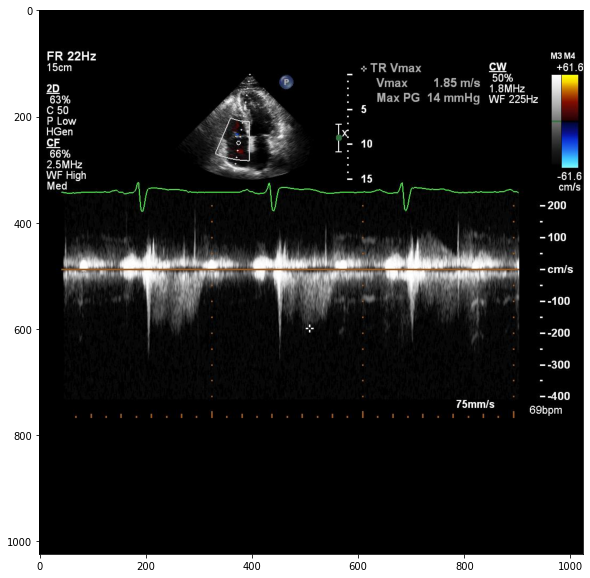

In [ ]:
pos = 5
img = cv2.imread(os.path.join(IMAGE_PATHS,filenames[pos]))
mask = cv2.imread(os.path.join(MASK_PATHS,filenames[pos][:-3] + 'png'), 0)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

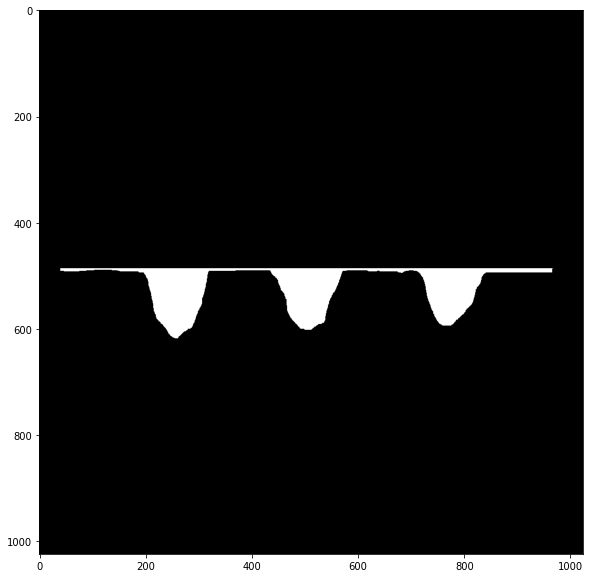

In [ ]:
plt.imshow(mask, cmap='gray')

[258, 506, 767]
...............................................: 216.0337552742616cm/s
...............................................: 189.0295358649789cm/s
...............................................: 175.52742616033754cm/s


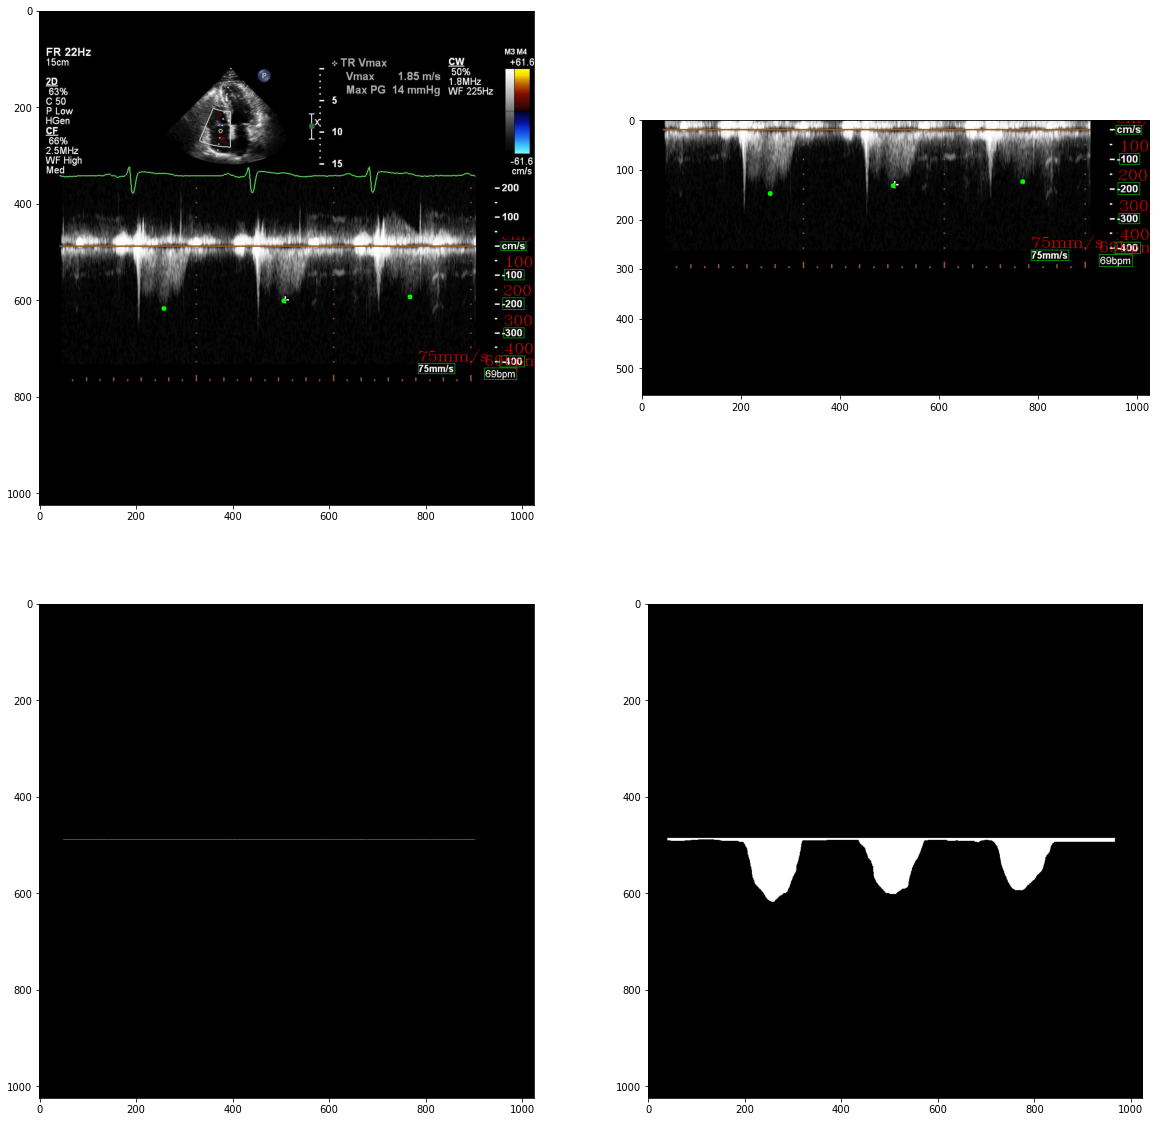

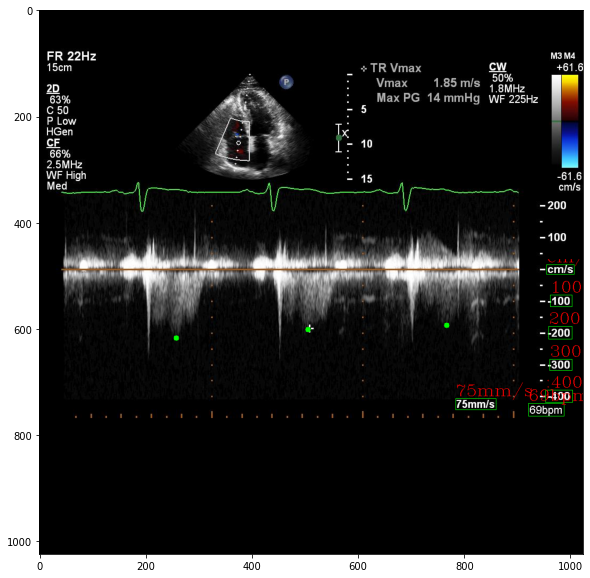

velocity is: [216.0337552742616, 189.0295358649789, 175.52742616033754]


In [ ]:
max_velocity, viz_img = get_peek_beat(img, mask)

plt.imshow(cv2.cvtColor(viz_img, cv2.COLOR_BGR2RGB))
plt.show()
print(f'velocity is: {max_velocity}')